In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os

rng = np.random.default_rng() # the Random Generator used throughout the script
DEBUG_VARIABLES = True # debug variables
SAVE_FIGURES = False # save figures for latex
DISPLAY_FIGURES = True # display figures in notebook
saved_figures = []
LOSSES = np.loadtxt('Milano_timeseries.csv', delimiter=',')

In [2]:
###########################################################
# Utilities
###########################################################

class Figure:
    def __init__(self, title, xlabel, ylabel, x, ys, legends, filename):
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if type(ys) is tuple:
            for y in ys:
                plt.plot(x,y)
        else:
            plt.plot(x,ys)
        plt.legend(legends, loc = "best", frameon = False)
        self.filename = filename
        self.save_figure_or_continue()
    def save_figure_or_continue(self):
        plt.show
        if DISPLAY_FIGURES: 
            plt.savefig(self.filename + ".png", bbox_inches = "tight")
            saved_figures.append(self.filename + ".png")
        if SAVE_FIGURES: plt.savefig("../latex/figures/" + self.filename + ".png", bbox_inches = "tight")
        plt.close()

def display_figures():
    """ A utility to display saved figures inside this notebook
    """
    filelist=os.listdir()
    for file in saved_figures:
        display.display(display.Image(file))

def delete_figures():
    """ A utility to delete saved figures
    """
    filelist=os.listdir()
    for file in saved_figures:
        os.remove(file)

def debug_variable(value):
    """ A utility to debug an object's inner properties in Jupyter
    """
    if DEBUG_VARIABLES:
        return value
    
def unique_random(size = 1):
    """ Returns a list -of a given size- of unique random floats in the range of 0 <= x <= 1
    """
    floats = []
    floats_seen = set()
    for i in range(size):
        new_float = rng.random()
        while new_float in floats_seen:
            new_float = rng.random()
        floats_seen.add(new_float)
        floats.append(new_float)
    return floats

class MAB:
    def __init__(self, total_time, dataset):
        self.total_time = total_time # horizon T
        self.dataset = dataset
        self.bandits_num = dataset[:,1].size # number of armed bandits k
        self.rng = np.random.default_rng()
        self._find_best()

    def _find_best(self):
        """ Find best bandit in given dataset
        """
        total_score = np.sum(self.dataset[:,0:self.total_time], axis=1)
        self.best_arm = np.argmax(total_score)
        self.best_score_t = self.dataset[self.best_arm,0:self.total_time] # best expected reward at each time t
        self.best_score = np.cumsum(self.best_score_t) # cumulative score of best arm at time t

    def _reset_env(self):
        """ Resets all helper variables
        """
        self.pulls = np.zeros(self.bandits_num) # total number of arm pulls (Qi)
        self.bandit_score = np.zeros(self.bandits_num) # total score of each bandit
        self.mu_estimate = np.inf*np.ones(self.bandits_num) # the estimate mu of each arm i until now, initialized at Inf (each bandit will be chosen at least once)
        self.ucb = np.inf*np.ones(self.bandits_num) # the metric based on which the UCB algorithm picks the best arm to play
        self.alg_score = np.zeros(self.total_time) # cumulative score of algorithm at time t
        self.alg_score_t = np.zeros(self.total_time) # average reward per iteration received until now
        self.inst_score = np.zeros(self.total_time) # reward of selected arm at time t
        self.regret_t = np.zeros(self.total_time) # average regret per iteration at round t
        self.selected_arms = np.zeros(self.total_time) # selected arm at time t


    def _play_arm(self, selected_arm, time):
        """ Takes care of the picking arm action, updating the state (all helper variables) of the algorithm
        """
        self.selected_arms[time] = selected_arm
        self.inst_score[time] = self.dataset[selected_arm,time]
        self.pulls[selected_arm] += 1
        self.bandit_score[selected_arm] += self.inst_score[time]
        self.alg_score[time] = self.inst_score[time] + (self.alg_score[time-1] if time>0 else 0)
        self.alg_score_t[time] = self.alg_score[time]/(time+1)
        self.mu_estimate[selected_arm] = self.bandit_score[selected_arm]/self.pulls[selected_arm]
        self.ucb[selected_arm] = self.mu_estimate[selected_arm] + pow(np.log(self.total_time)/self.pulls[selected_arm], 1/2) 
        self.regret_t[time] = (self.best_score[time] - self.alg_score[time])/(time+1)

    def upper_confidence_bound(self):
        """ An Upper Confidence Bound (UCB) algorithm implementation
        """
        self._reset_env()
        for time in range(self.total_time):
            selected_arm = np.argmax(self.ucb)
            self._play_arm(selected_arm, time)

In [3]:
###########################################################
# Run algorithms & generate figures
###########################################################

# simulated scenarios
t_array = [1000, LOSSES[1,:].size] # values for horizon T (total_time)

for i in range(len(t_array)):

    ###########################################################
    # Upper Confidence Bound
    ###########################################################

    mab_obj = MAB(total_time = t_array[i], dataset = -LOSSES) # input negated since ucb algorithm was build for maximizing rewards instead of minimizing losses 
    mab_obj.upper_confidence_bound()

    ucb_score = mab_obj.alg_score
    ucb_score_t = mab_obj.alg_score_t
    ucb_regret_t = mab_obj.regret_t

    ucb_estimate = debug_variable(mab_obj.ucb)
    selected_arms_ucb = debug_variable(mab_obj.selected_arms)
    pulls_ucb = debug_variable(mab_obj.pulls)

    ###########################################################
    # Plot Reward
    ###########################################################

    Figure(
        title = "MABs Total Loss Comparison (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time),
        xlabel = "Round t",
        ylabel = "Total Loss",
        x = np.arange(1,mab_obj.total_time+1),
        ys = (-ucb_score, -mab_obj.best_score), # output negated to show losses as positive amounts 
        legends = ("UCB", "Best Arm = %d" % mab_obj.best_arm),
        filename = "total_loss_%d_%d" % (mab_obj.bandits_num, mab_obj.total_time)
    )

    ###########################################################
    # Plot Average Reward
    ###########################################################

    Figure(
        title = "MABs Average Loss Comparison (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time),
        xlabel = "Round t",
        ylabel = "Average Loss",
        x = np.arange(1,mab_obj.total_time+1),
        ys = (-ucb_score_t, -mab_obj.best_score_t),
        legends = ("UCB", "Best Arm = %d" % mab_obj.best_arm),
        filename = "average_loss_%d_%d" % (mab_obj.bandits_num, mab_obj.total_time)
    )

    ###########################################################
    # Plot Regret
    ###########################################################
    Figure(
        title = "MABs Regret Comparison (k = %d, T = %d)" % (mab_obj.bandits_num, mab_obj.total_time),
        xlabel = "Round t",
        ylabel = "Average Regret",
        x = np.arange(1,mab_obj.total_time+1),
        ys = ucb_regret_t,
        legends = ("UCB", ""),
        filename = "average_regret_%d_%d" % (mab_obj.bandits_num, mab_obj.total_time)
    )

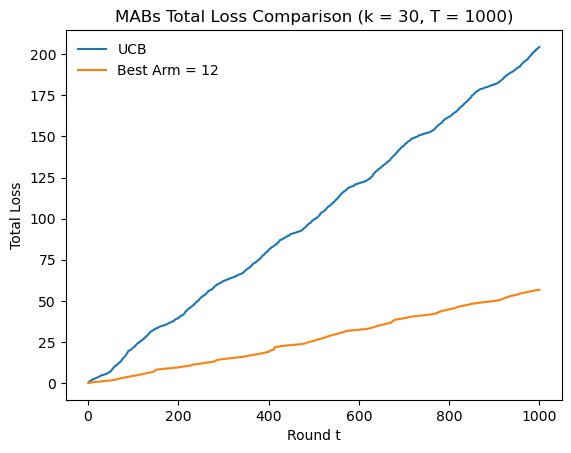

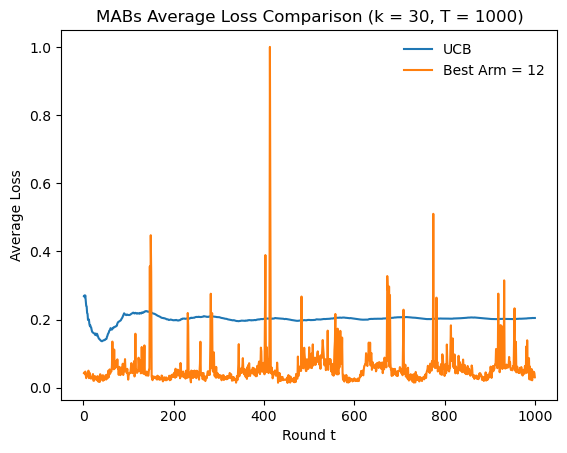

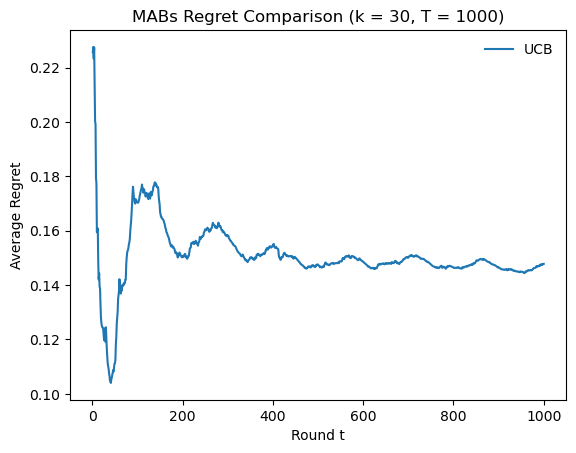

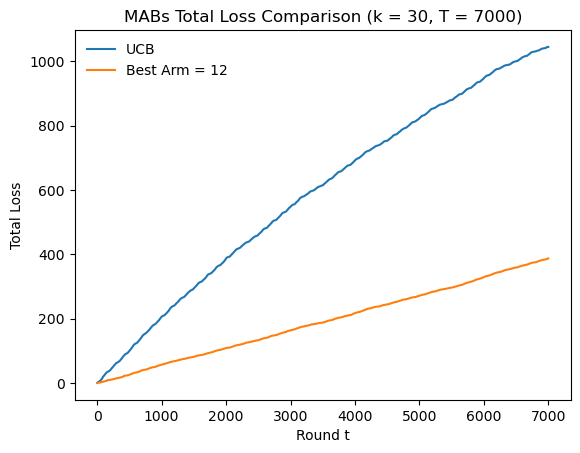

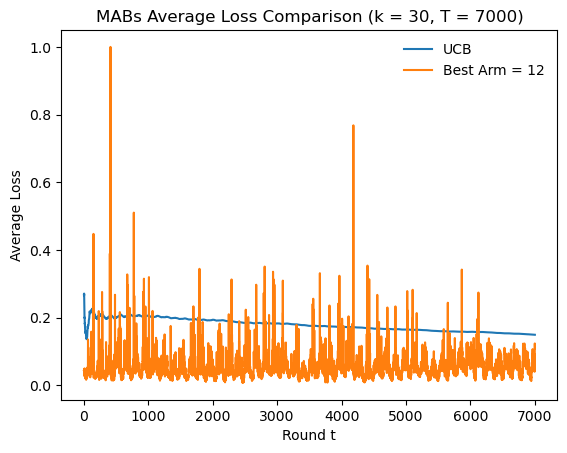

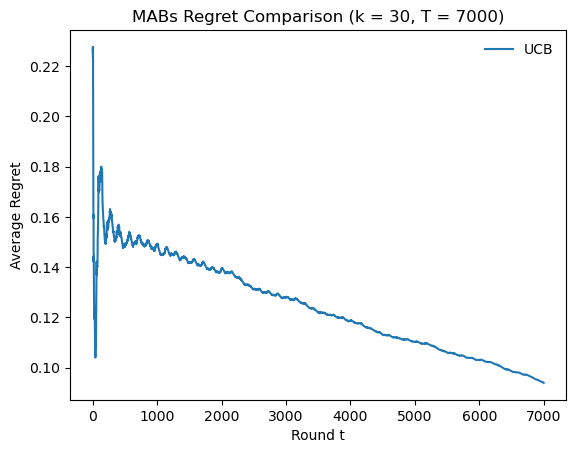

In [4]:
###########################################################
# Load generated figures & clean folder
########################################################### 

if DISPLAY_FIGURES: 
    display_figures()
    delete_figures()